In [1]:
%%HTML
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [2]:
# Google Colab環境ではGoogle Driveをマウントしてアクセスできるようにします。
import sys

if 'google.colab' in sys.modules:
    # Google Drive をマウントします
    from google.colab import drive
    mount_dir = "/content/drive"
    drive.mount(mount_dir)

Mounted at /content/drive


# シンプルなポートフォリオ組成モデルの作成

```
　バックテストの実行方法を理解したので、いよいよシンプルなポートフォリオ組成モデルを作成しましょう。ポートフォリオ組成モデルを作成することを通して、本コンペティションに投稿するモデルの出力や評価方法を把握し、最終的には作成したモデルを投稿して結果がリーダーボードに掲載されることを確認します。

　本節では以下を説明しています。

- ポートフォリオ組成モデルの作成方法
- バックテストの使用方法
- 投稿用パッケージの作成方法

　具体的には、以下のステップで進めていきます。

[source]
----
1. 必要なライブラリの読み込み
2. データセットの読み込み
3. ポートフォリオ組成戦略の策定
4. ポートフォリオの組成
5. 出力の調整
6. バックテストの実行
7. バックテストの評価
8. 投稿用パッケージのディレクトリ作成
9. 作成したコードをランタイム実行用にクラスにまとめる
10. 提出用パッケージの作成と提出
----
```

## 必要な入力データ等

```
■バックテスト用クラス +
本コンペティションの評価方法と同等のロジックを実装したバックテスト用のクラスを提供しています。本notebookからimportできる必要があります。import時にエラーとなる場合は、`backtest.py` ファイルをダウンロードしている確認の上、sys.path に追加して再実行してください。なお、バックテスト用のクラスの取得方法は、<<anchor-3.6 ,3.6. バックテスト環境の構築>>をご参照ください。

■データセット +
本章で構築するモデルにおいては、以下のデータファイルを使用します。そのため、コンペティションサイトからダウンロードしたデータファイルを配置し、ディレクトリパスを `dataset_dir` 変数に設定してください。

- stock_list.csv.gz
- stock_price.csv.gz
```

## 1. 必要なライブラリの読み込み

ランタイム環境とGoogle Colaboratory環境の両者で共通のライブラリを使用するためにバージョンを調整します。

In [3]:
# ライブラリのバージョンを調整します
!pip install --no-cache-dir joblib==1.0.1 numpy==1.19.5 pandas==1.1.5 scikit-learn==0.20.3 scipy==1.2.1 seaborn==0.9.0

     |████████████████████████████████| 5.4MB 5.5MB/s 
     |████████████████████████████████| 24.8MB 45.5MB/s 
     |████████████████████████████████| 215kB 54.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


In [4]:
import io
import os
import sys
import zipfile

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from scipy import stats
from IPython.core.magic import register_cell_magic

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


　次に本コンペティションの評価検証用のバックテストモジュールを読み込みます。インポート時にエラーが出た場合は、sys.path に backtest.py ファイルを配置したディレクトリを追加してから再度インポートしてください。

In [5]:
# インポート時にエラーが出た場合は、以下のmodule_dirをbacktest.pyを配置したディレクトリに変更してください。
import sys
if 'google.colab' in sys.modules:
  # Backtestを配置したディレクトリへのフルパスを指定します
  module_dir = f"{mount_dir}/MyDrive/JPX_Competition/Chapter03/backtest"
else:
  # Backtestを配置したディレクトリへのフルパスを指定します
  module_dir = "/notebook/Chapter03/backtest" 
sys.path.append(module_dir)

from backtest import Backtest

Pandasのデータを表示する際に表略されないように設定を変更します

In [6]:
# 表示用の設定を変更します
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

## 2. データセットの読み込み

```
　データセットを配置したディレクトリのパスを設定します。Google Colabをご利用の場合は Google Drive にデータセットをアップロードして、そのディレクトリを指定してください。また、データセットの取得方法および内容については「<<anchor-3.4, 3.4. データセットの説明>>」をご参照ください。
```

In [7]:
# データセットを配置したディレクトリのパスを設定
if 'google.colab' in sys.modules:
    dataset_dir = f"{mount_dir}/MyDrive/JPX_Competition/data_dir_comp2"
else:
    dataset_dir = "/notebook/data_dir_comp2"

　本コンペティションのランタイム環境におけるデータセットへのアクセスは、 `ScoringService.predict()` メソッドに渡されるinputsパラメーターを通して行う必要があります。そのため、以下のように本notebook環境でもランタイム環境と共通の方法でデータセットにアクセスすることで、コードが複雑になったり投稿用にコードを編集したりしなくても済むようにしています。

In [8]:
# 入力パラメーターを設定します。ランタイム環境での実行時と同一フォーマットにします
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
}

　本コンペティションでは2016年以降のデータを提供していますが、本notebookではモデル作成・評価時の処理時間を短くするために 2020-01-01 以降のデータを使用してバックテストを実施・評価します。なお、実際に評価をする場合は可能な限り長い期間を評価に利用することを推奨します。

In [9]:
# 投資対象日付を指定します
start_dt = pd.Timestamp("2020-01-01")

　ランタイム環境においては `ScoringService.predict()` メソッドに渡されるinputsパラメーターに `purchase_date` というキー名で予測対象日が記載されたCSV形式のファイルへのパスが渡され、そのファイル内に記載されている日付を予測対象日として使用します。ここではランタイム環境に対応するために `purchase_date` が存在する場合は、指定された日付を使用するロジックを組み込んでおきます。purchase_date のフォーマットについては link:https://signate.jp/competitions/443/data[SIGNATEのコンペティションサイト] にサンプルファイルが配置されているためそちらをご参照ください。

In [10]:
if "purchase_date" in inputs.keys():
    # ランタイム環境では指定された投資対象日付を使用します
    # purchase_dateを読み込み
    df_purchase_date = pd.read_csv(inputs["purchase_date"])
    # purchase_dateの最も古い日付を投資対象日付として使用します
    start_dt = pd.Timestamp(df_purchase_date.sort_values("Purchase Date").iloc[0, 0])

　本コンペティションでは投資対象となる銘柄群 (ユニバース) が設定されています。そのため、ユニバース内の銘柄に絞って処理を実施するために銘柄情報を読み込みます。

In [11]:
# 銘柄情報読み込み
df_stock_list = pd.read_csv(inputs["stock_list"])
# 問題2のユニバース (投資対象の条件を満たす銘柄群) 取得
codes = df_stock_list.loc[
    df_stock_list.loc[:, "universe_comp2"] == True, "Local Code"
].unique()

　以下では、シンプルに株価情報のみを利用してポートフォリオを組成するために株価情報を読み込んでいます。本コンペティションでは、データセットはcsv.gz形式で提供していますので、データの型情報が保存されていません。そのため、特に日付型のカラムについては明示的に変換する必要があります。read_csvのparse_dateパラメーター等、日付型を指定する方法は複数ありますが、本notebookでは一度読み込んでから変換しています。

In [12]:
# 価格情報読み込み、インデックス作成
df_price = pd.read_csv(inputs["stock_price"]).set_index("EndOfDayQuote Date")
# 日付型に変換
df_price.index = pd.to_datetime(df_price.index, format="%Y-%m-%d")

　処理時間を最適化するために処理対象データを日付でフィルタをして絞り込みます。本notebookでは過去20営業日のデータを使用して特徴量を作成するため、投資対象日付から過去20営業日時点のデータを含める必要がありますが、バッファとして過去30日のデータを含めることにします。同時に株価情報をユニバースと一致するように絞り込んでいます。

In [13]:
# 投資対象日の前週金曜日時点で予測を出力するため、予測出力用の日付を設定します。
pred_start_dt = pd.Timestamp(start_dt) - pd.Timedelta("3D")
# 特徴量の生成に必要な日数をバッファとして設定
n = 30
# データ絞り込み日付設定
data_start_dt = pred_start_dt - pd.offsets.BDay(n)
# 日付で絞り込み
filter_date = df_price.index >= data_start_dt
# 銘柄をユニバースで絞り込み
filter_universe = df_price.loc[:, "Local Code"].isin(codes)
# 絞り込み実施
df_price = df_price.loc[filter_date & filter_universe]

　`head()` や `tail()` メソッドを使用して処理結果が期待通りとなっていることを確認しながら進めていきます。ここではデータが2019年11月20日以降に絞り込まれていることが確認できます。`.T`  プロパティ https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html#pandas.DataFrame.transpose を使用して行と列を入れ替えることで可読性が上がる場合があります。

　ここで計算したデータセットのフォーマットを確認するために、データセットの先頭を見てみます。

In [14]:
df_price.head(3).T

EndOfDayQuote Date,2019-11-18,2019-11-19,2019-11-20
Local Code,1301,1301,1301
EndOfDayQuote Open,2941,2930,2939
EndOfDayQuote High,2941,2948,2939
EndOfDayQuote Low,2923,2926,2883
EndOfDayQuote Close,2935,2938,2895
EndOfDayQuote ExchangeOfficialClose,2935,2938,2895
EndOfDayQuote Volume,14200,12800,35700
EndOfDayQuote CumulativeAdjustmentFactor,1,1,1
EndOfDayQuote PreviousClose,2923,2935,2938
EndOfDayQuote PreviousCloseDate,2019/11/15,2019/11/18,2019/11/19


## 3. ポートフォリオ組成戦略の策定

```
　ポートフォリオを組成するための特徴量を作成します。今回は以下の2種類の戦略を採用します。

1. リターン・リバーサル (逆張り) 戦略を採用して、過去1ヶ月(約20営業日)の株価下落率の上位25銘柄を選択します。
(「リターン・リバーサル」 野村證券証券用語解説集より引用 https://www.nomura.co.jp/terms/japan/ri/A01944.html)
2. トレンドフォロー (順張り) 戦略を採用して、過去1ヶ月(約20営業日)の株価上昇率の上位25銘柄を選択します。
(「トレンドフォロー」 野村證券証券用語解説集より引用 https://www.nomura.co.jp/terms/japan/ta/A02002.html)

　過去1ヶ月(20営業日)の株価下落率/上昇率を計算するために、銘柄毎にグループ化してから株価変化率を計算します。 +
　本コンペティションに提出するポートフォリオは各週の週初の営業日に買付実施されるため、買付日前週の金曜日終値時点を銘柄選択の基準とします。基準日のデータを取得するために単純に金曜日にのみ絞り込んだ場合、金曜日が祝日の場合にその翌週の銘柄を選択できなくなるおそれがあるため、平日でリサンプル(pandasにおいて平日を意味する ``B`` を指定してresample関数を呼んでいます)し、欠損値がある場合には前日の値を使うように前方補完(pandasではffill関数を利用)を実施します。これにより、金曜日に必ずデータが存在するようにしています。
```

In [15]:
# 欠損値がある場合にも正しく動作しているかを確認するため、処理前に木曜日、金曜日が祝日である2020-07-23、2020-07-24のレコードが存在しないことを確認しておきます。
df_price.loc["2020-07-22":"2020-07-27"].head(4)

,Local Code,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP
EndOfDayQuote Date,,,,,,,,,,,,,,,
2020-07-22,1301,2770.0,2770.0,2720.0,2720.0,2720.0,8900.0,1.0,2773.0,2020/07/21,2773.0,2020/07/21,-53.0,-1.911,2744.180
2020-07-27,1301,2720.0,2728.0,2700.0,2720.0,2720.0,13100.0,1.0,2720.0,2020/07/22,2720.0,2020/07/22,0.0,0.000,2712.710
2020-07-22,1332,475.0,475.0,463.0,463.0,463.0,1009300.0,1.0,473.0,2020/07/21,473.0,2020/07/21,-10.0,-2.114,466.618
2020-07-27,1332,462.0,468.0,456.0,468.0,468.0,1383200.0,1.0,463.0,2020/07/22,463.0,2020/07/22,5.0,1.080,464.488


In [16]:
# groupby を使用して処理するために並び替え
df_price.sort_values(["Local Code", "EndOfDayQuote Date"], inplace=True)
# 銘柄毎にグループにします。
grouped_price = df_price.groupby("Local Code")[
    "EndOfDayQuote ExchangeOfficialClose"
]
# 銘柄毎に20営業日の変化率を作成してから、金曜日に必ずデータが存在するようにリサンプルして前方補完します。
#df_feature = grouped_price.apply(
#    lambda x: x.pct_change(20).resample("B").ffill().dropna()
#).to_frame()

# 銘柄毎に終値と25営業日の単純移動平均線の乖離を作成してから、金曜日に必ずデータが存在するようにリサンプルしてフィルします
df_feature = grouped_price.apply(
    lambda x: (x / (x.rolling(25).mean())).resample("B").ffill().dropna()
).to_frame()


　大量のデータを処理する場合、処理によっては数分から数時間かかる場合があります。処理済みのデータを保存しておくことで、処理時間のかかる処理を省略して作業できるようにすることは重要なテクニックの一つです。今回はメモリ上に別の変数として保存しておきますが、セッションが閉じられる際に処理済みデータもクリアされてしまうことに加えて、大量のデータである場合はメモリ上に保存しておくとメモリを圧迫するため、ファイルに書き出しておいて必要な時にファイルから読み込むのが良い方法です。

　Pandasには様々な形式でのデータの入出力用メソッド (link:https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html[リンク]) が用意されています。例えば、データが圧縮されて型が保存される `to_hdf` メソッド (link:https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_hdf.html[リンク])を使用してファイルに書き出し、対応する `read_hdf` メソッド (link:https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_hdf.html[リンク])で読み出すことで簡単にデータフレームを読み書きできます。

　平日を指定してデータのリサンプル行い、欠損値に前日の値を使うように前方補完した結果が期待通りになっているかを確認しましょう。2020-07-23及び2020-07-24はそれぞれ木曜日及び金曜日の祝日でしたので、2020-07-23及び2020-07-24に2020-07-22の値が入っていれば良いことになります。

In [17]:
# 上記は比較的時間のかかる処理なので、処理済みデータを別に残しておきます。
df_work = df_feature.copy()

In [18]:
# 処理後に木曜日、金曜日が祝日である2020-07-23、2020-07-24のレコードが前方補完されていることを確認します。
df_work.loc[(slice(None), slice("2020-07-22", "2020-07-27")),].head(4)

EndOfDayQuote ExchangeOfficialClose
Local Code EndOfDayQuote Date                                     
1301       2020-07-22                                     1.001060
           2020-07-23                                     1.001060
           2020-07-24                                     1.001060
           2020-07-27                                     1.000839

　以下のコードでデータを整えます。インデックスとカラム名を調整しています。

In [19]:
# インデックスが銘柄コードと日付になっているため、日付のみに変更します。
df_work = df_work.reset_index(level=[0])
# カラム名を変更します。 
df_work.rename(
    columns={"EndOfDayQuote ExchangeOfficialClose": "pct_change"},
    inplace=True,
)
# データをpred_start_dt以降の日付に絞り込みます。
df_work = df_work.loc[df_work.index >= pred_start_dt]

特徴量が生成されていることを確認します。

In [20]:
# df_workの最初の3行を出力する。
df_work.head(3)

,Local Code,pct_change
EndOfDayQuote Date,,
2019-12-30,1301,1.002958
2019-12-31,1301,1.002958
2020-01-01,1301,1.002958


## 4. ポートフォリオの組成

　今回のポートフォリオでは買付日前週の金曜日終値時点を銘柄選択の基準とするため、金曜日のデータのみに絞り込みます。すでに「<<anchor-3.7.4,3.7.4. ポートフォリオ構築戦略の策定>>」において、金曜日が祝日の場合の処理はしていますので、そのまま金曜日に絞り込んで問題ありません。

In [21]:
# 金曜日のデータのみに絞り込みます
df_work = df_work.loc[df_work.index.dayofweek == 4]

　金曜日のデータのみとなっていることを確認します

In [22]:
# df_workの最初の2行を出力する。
df_work.head(2)

,Local Code,pct_change
EndOfDayQuote Date,,
2020-01-03,1301,1.002958
2020-01-10,1301,1.023357


　次に、日付毎にグループ化してから、下落率上位25銘柄を選択しています。本コンペティションの評価では、出力されたポートフォリオに記載されている順番で銘柄が購入されるため、なるべくリターンが高くなる銘柄から先に出力して購入されるようにすることが最適と考えられます。ここでは、下落率が高い銘柄ほどリターンの大きくなるとの仮説を立てて、`pct_change` について昇順で並べ替えてから銘柄を選択しています。こうすることで下落率が高い銘柄順に出力されるようにしています。

　なお、ここでは説明をシンプルにするために特に理由なく25銘柄を選択していますが、例えば、5銘柄から50銘柄まで5銘柄ずつ増加させた合計10個のポートフォリオを組成してバックテストでパフォーマンスを比較することで、この戦略における最適な選択銘柄数を見つけられるかもしれません。また、その場合、50銘柄のポートフォリオを組成しておいて、バックテスト投入時に銘柄数を絞り込むロジックを組むことで処理時間を最適化できるかもしれません。

In [23]:
# 日付毎に処理するためグループ化します
grouped_work = df_work.groupby("EndOfDayQuote Date", as_index=False)

In [24]:
# 選択する銘柄数を指定します
number_of_portfolio_stocks = 25

# ポートフォリオの組成方法を戦略に応じて調整します
strategies = {
    # リターン・リバーサル戦略
    "reversal": {"asc": True},
    # トレンドフォロー戦略
    "trend": {"asc": False},
}

# 戦略に応じたポートフォリオを保存します
df_portfolios = {}

# strategy_id が設定されていない場合は全ての戦略のポートフォリオを作成します
if "strategy_id" not in locals():
    strategy_id = None

for i in [strategy_id] if strategy_id is not None else strategies.keys():
    #  日付毎に戦略に応じた上位25銘柄を選択します。
    df_portfolios[i] = grouped_work.apply(
        lambda x: x.sort_values(
            "pct_change", ascending=strategies[i]["asc"]
        ).head(number_of_portfolio_stocks)
    )

```
　以下を確認します。

1. 1つの週に対して25銘柄選択されていること
2. 戦略に応じてpct_changeの値が反転していること
```

In [25]:
# 結果結合用
buff = []
# 戦略毎に処理
for i in df_portfolios.keys():
    # ポートフォリオを表示用に保存
    buff.append(
        df_portfolios[i]
        # マルチインデックスは操作しにくいので日付のみに変更します
        .reset_index(level=[0])
        # 先頭の26レコードを取得します
        .head(26)
        # 結合した後の列名をわかりやすくするために変更します
        .rename(columns={v: f"{i}_" + v for v in df_portfolios[i].columns})
    )
# 結合して保存
pd.concat(buff, axis=1)

,level_0,reversal_Local Code,reversal_pct_change,level_0,trend_Local Code,trend_pct_change
EndOfDayQuote Date,,,,,,
2020-01-03,0,4592,0.738130,0,6387,1.490983
2020-01-03,0,4571,0.833533,0,4772,1.354751
2020-01-03,0,6049,0.843982,0,6195,1.349313
2020-01-03,0,3254,0.846557,0,6030,1.219085
2020-01-03,0,6875,0.857765,0,7033,1.212479
2020-01-03,0,7744,0.868079,0,4308,1.212410
2020-01-03,0,2395,0.868907,0,6196,1.209057
2020-01-03,0,3660,0.886429,0,5805,1.205606
2020-01-03,0,3549,0.893277,0,7065,1.202920


```
　ポートフォリオに組み入れる銘柄を決めたので、各銘柄について購入金額を指定します。今回はシンプルにするために50,000円を一律で指定して購入金額の総額を25銘柄分で合計125万とすることで、1株の価格が5万円を超えている銘柄が含まれていても予算上限に近い金額を購入できるようにしています。株価を参照して銘柄数や購入金額を調整することも検討してみてください。なお、本コンペティションのポートフォリオは、対象週の月曜日日付を指定する必要がありますので、金曜日から月曜日日付に変更しています。
```

In [26]:
# 銘柄ごとの購入金額を指定
budget = 50000
# 戦略毎に処理
for i in df_portfolios.keys():
    # 購入株式数を設定
    df_portfolios[i].loc[:, "budget"] = budget
        
    # インデックスを日付のみにします
    df_portfolios[i].reset_index(level=[0], inplace=True)
    # 金曜日から月曜日日付に変更
    df_portfolios[i].index = df_portfolios[i].index + pd.Timedelta("3D")

これでポートフォリオが完成しました。完成したデータを確認します。

In [27]:
# 戦略毎に処理
for i in df_portfolios.keys():
    # 戦略名を表示
    display(i)
    # 表示
    display(df_portfolios[i].head(3))

'reversal'

,level_0,Local Code,pct_change,budget
EndOfDayQuote Date,,,,
2020-01-06,0,4592,0.738130,50000
2020-01-06,0,4571,0.833533,50000
2020-01-06,0,6049,0.843982,50000


'trend'

,level_0,Local Code,pct_change,budget
EndOfDayQuote Date,,,,
2020-01-06,0,6387,1.490983,50000
2020-01-06,0,4772,1.354751,50000
2020-01-06,0,6195,1.349313,50000


　ポートフォリオ組成に用いた特徴量やその他のカラムが残っているため、本コンペティションで決められている出力フォーマットと一致するように出力を調整します。

## 5. 出力の調整

```
　本コンペティションのポートフォリオの出力フォーマットは「<<anchor-3.3.4, 3.3.4. 提出するモデルの予測出力の定義>>」をご参照ください。ここでは出力フォーマットに合わせるためにインデックス名やカラム数を調整します。
```

In [28]:
# 戦略毎に処理
for i in df_portfolios.keys():
    # インデックス名を設定
    df_portfolios[i].index.name = "date"
    # 出力するカラムを絞り込みます
    df_portfolios[i] = df_portfolios[i].loc[:, ["Local Code", "budget"]]

ポートフォリオが出力フォーマットと一致していることを確認します。

In [29]:
# 戦略毎に処理
for i in df_portfolios.keys():
    # ポートフォリオを確認
    display(df_portfolios[i].head(3))

,Local Code,budget
date,,
2020-01-06,4592,50000
2020-01-06,4571,50000
2020-01-06,6049,50000


,Local Code,budget
date,,
2020-01-06,6387,50000
2020-01-06,4772,50000
2020-01-06,6195,50000


　本コンペティションの `ScoringService.predict` の出力仕様はcsv形式の文字列であるため、仕様に合わせて出力します。

In [30]:
# 出力保存用
outputs = {}
# 戦略毎に処理
for i in df_portfolios.keys():
    # 出力します
    out = io.StringIO()
    # CSV形式で出力
    df_portfolios[i].to_csv(out, header=True)
    # 出力を保存
    outputs[i] = out.getvalue()

出力を確認します。

In [31]:
# 戦略毎に処理
for i in outputs.keys():
    # 戦略名を表示
    print(f'// "{i}"')
    # 出力を確認
    print("\n".join(outputs[i].split("\n")[:4]))

// "reversal"
date,Local Code,budget
2020-01-06,4592,50000
2020-01-06,4571,50000
2020-01-06,6049,50000
// "trend"
date,Local Code,budget
2020-01-06,6387,50000
2020-01-06,4772,50000
2020-01-06,6195,50000


バックテスト用に出力を保存しておきます。

In [32]:
# 戦略毎に処理
for i in outputs.keys():
    # 出力を保存します。
    with open(f"chapter03-tutorial-01-{i}.csv", mode="w") as f:
        # ポートフォリオをファイルに書き出し
        f.write(outputs[i])

## 6. バックテストの実行

```
　本コンペティションの Public LB および Private LB と同等の評価ロジックを実装したバックテスト用の `backtest.py` ファイルを使用して、作成したポートフォリオを評価します。
バックテストの使用法などの詳細は、「<<anchor-3.6, 3.6. バックテスト環境の構築>>」をご参照ください。

　初めにバックテストを使用する際に必要なデータを準備します。バックテストの実行には以下の3つのデータが必要になります。

1. ユニバース (stock_list.csv.gz)
2. 株価 (stock_price.csv.gz)
3. テスト対象のポートフォリオ

　`Backtest.prepare_data` に1および2のデータを保存しているディレクトリへのパスを指定して、必要なデータをロードします。
```

In [33]:
# データを保存しているディレクトリを指定します。
backtest_dataset_dir = dataset_dir
# バックテストに必要なデータを読み込みます。
backtest_codes, backtest_price = Backtest.prepare_data(backtest_dataset_dir)

　バックテスト対象の戦略であるリターン・リバーサル戦略とトレンドフォロー戦略を定義します。

In [34]:
# ポートフォリオの組成方法
backtest_strategies = {
    # リターン・リバーサル戦略
    "reversal": {},
    # トレンドフォロー戦略
    "trend": {},
}

```
　`Backtest.load_submit` にテスト対象のポートフォリオを保存したファイルへのパスを指定して読み込みます。`load_submit` ではデータを読み込み時にフォーマットのチェックをしたり、レコード順を付与するなどのバックテスト実行のための前処理を実施しています。
```

In [35]:
# ポートフォリオデータ保存用
df_submits = {}
# 先ほど出力したポートフィリオデータを読み込みます
for i in backtest_strategies.keys():
    # ポートフォリオを読み込み
    df_submits[i] = Backtest.load_submit(f"chapter03-tutorial-01-{i}.csv")

3つのデータを指定してバックテストを実行します。

In [36]:
# バックテスト結果リターン情報保存用
results = {}
# バックテスト結果銘柄情報保存用
stocks = {}
# 戦略毎に処理
for i in tqdm(backtest_strategies.keys()):
    # バックテストを実行します
    results[i], stocks[i] = Backtest.run(df_submits[i], backtest_codes, backtest_price)

返り値を確認します。評価は下記で実施します。

In [37]:
# バックテスト結果のサマリー
results["reversal"].tail(5)

,day_1,day_2,day_3,day_4,day_5,date,holiday,bought,cash,week_pl,week_return,day_1_return,day_1_pl,day_2_return,day_2_pl,day_3_return,day_3_pl,day_4_return,day_4_pl,day_5_return,day_5_pl,exp,std,sharp
47,1000896.0,1016827.0,1028704.0,1003232.0,996203.0,2020-11-30,[],998971.0,1029.0,-3797.0,-0.3797,0.0896,896.0,1.591674,15931.0,1.168045,11877.0,-2.476125,-25472.0,-0.700636,-7029.0,-0.065488,1.620681,-0.040408
48,963327.0,976358.0,968286.0,962146.0,996010.0,2020-12-07,[],999621.0,379.0,-3990.0,-0.3990,-3.6673,-36673.0,1.352708,13031.0,-0.826746,-8072.0,-0.634110,-6140.0,3.519632,33864.0,-0.051163,2.680449,-0.019088
49,1000548.0,974301.0,964530.5,985110.0,969965.0,2020-12-14,[],999409.5,590.5,-30035.0,-3.0035,0.0548,548.0,-2.623262,-26247.0,-1.002822,-9770.5,2.133629,20579.5,-1.537392,-15145.0,-0.595009,1.805265,-0.329597
50,986008.0,943343.0,960949.0,964466.0,960225.0,2020-12-21,[],999819.0,181.0,-39775.0,-3.9775,-1.3992,-13992.0,-4.327044,-42665.0,1.866341,17606.0,0.365992,3517.0,-0.439725,-4241.0,-0.786727,2.312840,-0.340156
51,993104.0,1021154.0,1023035.0,1023035.0,1023035.0,2020-12-28,"[3, 4]",999931.0,69.0,23035.0,2.3035,-0.6896,-6896.0,2.824478,28050.0,0.184203,1881.0,0.000000,0.0,0.000000,0.0,0.773027,1.829541,0.422525


In [38]:
# バックテスト結果のサマリー
results["trend"].tail(5)

,day_1,day_2,day_3,day_4,day_5,date,holiday,bought,cash,week_pl,week_return,day_1_return,day_1_pl,day_2_return,day_2_pl,day_3_return,day_3_pl,day_4_return,day_4_pl,day_5_return,day_5_pl,exp,std,sharp
47,994731.0,1001768.0,996243.0,1002517.0,1019088.0,2020-11-30,[],999684.0,316.0,19088.0,1.9088,-0.5269,-5269.0,0.707427,7037.0,-0.551525,-5525.0,0.629766,6274.0,1.652940,16571.0,0.382342,0.932757,0.409905
48,928220.0,946308.0,940056.0,922983.0,941815.0,2020-12-07,[],999275.0,725.0,-58185.0,-5.8185,-7.1780,-71780.0,1.948676,18088.0,-0.660673,-6252.0,-1.816168,-17073.0,2.040341,18832.0,-1.133165,3.768244,-0.300714
49,1036031.0,1009881.0,1022601.0,1011308.0,1005337.0,2020-12-14,[],998724.0,1276.0,5337.0,0.5337,3.6031,36031.0,-2.524056,-26150.0,1.259554,12720.0,-1.104341,-11293.0,-0.590423,-5971.0,0.128767,2.367748,0.054384
50,983235.0,936905.0,956344.0,977378.0,981720.0,2020-12-21,[],999744.0,256.0,-18280.0,-1.8280,-1.6765,-16765.0,-4.711997,-46330.0,2.074810,19439.0,2.199418,21034.0,0.444250,4342.0,-0.334004,2.906691,-0.114909
51,996013.0,1001647.0,1003131.0,1003131.0,1003131.0,2020-12-28,"[3, 4]",999105.0,895.0,3131.0,0.3131,-0.3987,-3987.0,0.565655,5634.0,0.148156,1484.0,0.000000,0.0,0.000000,0.0,0.105037,0.483621,0.217189


In [39]:
# 銘柄毎の情報
stocks["reversal"].tail(5)

,date,Local Code,budget,n,entry,day_1,day_2,day_3,day_4,day_5,bought,actual
20,2020-12-28,2678,50000,1295,3725.0,3775.0,3750.0,3850.0,0.0,0.0,29800.0,8
21,2020-12-28,4382,50000,1296,2500.0,2427.0,2576.0,2658.0,0.0,0.0,0.0,0
22,2020-12-28,4344,50000,1297,264.0,259.0,275.0,280.0,0.0,0.0,0.0,0
23,2020-12-28,6195,50000,1298,4700.0,4555.0,4530.0,4495.0,0.0,0.0,0.0,0
24,2020-12-28,4499,50000,1299,2967.0,2875.0,2970.0,2973.0,0.0,0.0,0.0,0


In [40]:
# 銘柄毎の情報
stocks["trend"].tail(5)

,date,Local Code,budget,n,entry,day_1,day_2,day_3,day_4,day_5,bought,actual
20,2020-12-28,7745,50000,1295,1179.0,1200.0,1289.0,1281.0,0.0,0.0,27117.0,23
21,2020-12-28,1407,50000,1296,4850.0,4770.0,4805.0,4745.0,0.0,0.0,0.0,0
22,2020-12-28,6095,50000,1297,7660.0,7660.0,8060.0,8160.0,0.0,0.0,0.0,0
23,2020-12-28,6871,50000,1298,1293.0,1289.0,1313.0,1298.0,0.0,0.0,0.0,0
24,2020-12-28,7033,50000,1299,1781.0,1801.0,2006.0,1949.0,0.0,0.0,0.0,0


## 7. バックテストの評価

```
　バックテストを実行して取得した、週毎のリターン情報と各銘柄毎の購入結果数の情報を評価していきます。各評価項目の定義については、「<<anchor-3.6.4, 3.6.4. バックテストの評価軸と取引戦略>>」をご参照ください。

　結果の評価として以下を実施します。

*週毎のリターンデータ*

1. 週毎の運用実績（PL）の分布をプロット (週毎の運用実績の合計値が本コンペティションの評価項目)
2. 週毎の運用実績の統計量の算出
3. 週毎の勝率・ペイオフレシオ・シャープレシオの算出
4. 週毎のリターン推移のプロット
5. 曜日別分析のためのバイオリンプロット
6. 週毎のリターンの累積プロット
7. ユニバースとの散布図
8. ユニバースに対するベータを計算
```

### 1. 週毎の運用実績（PL）の分布をプロット (週毎の運用実績の合計値が本コンペティションの評価項目)

　まず、週毎の運用実績の分布をプロットしてみます。

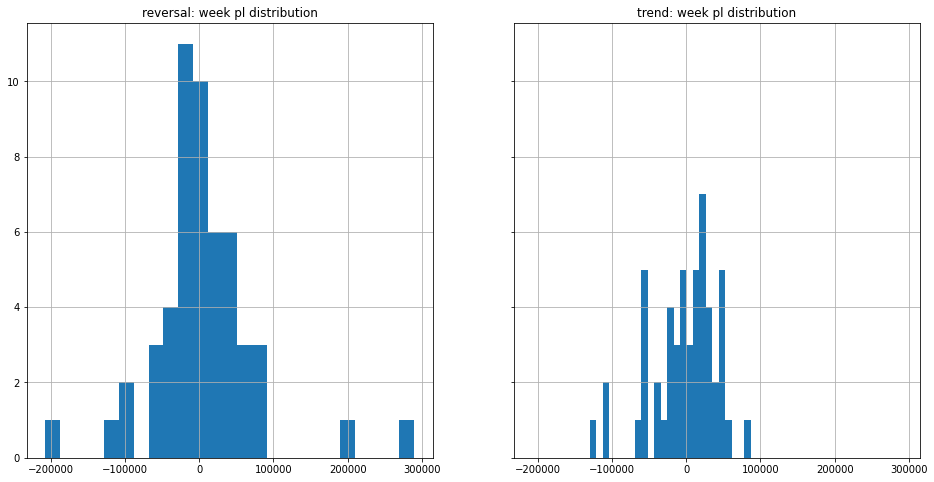

In [41]:
# 描画領域を定義
fig, axes = plt.subplots(1, len(results), figsize=(8 * len(results), 8), sharex=True, sharey=True)

# 戦略毎に処理
for i, k in enumerate(results.keys()):
    # 描画位置を指定
    ax = axes[i]
    # 分布をプロット
    results[k].week_pl.hist(bins=25, ax=ax)
    # タイトルを設定
    ax.set_title(f"{k}: week pl distribution")
#　描画
plt.show()

　trendとreversalは共にほぼ0平均に見えますが、reversalは分布が若干広いように見え、週によっては大きなマイナスも観測されていることがわかります。おそらくCOVID-19の暴落が発生した週が該当すると想像できます。ただし、大きなプラスの週もあるため、その負けを取り返しているかもしれません。ただ、このプロットだけではあまり戦略の良し悪しはわかりません。

### 2. 週毎の運用実績の統計量の算出

　週毎の運用実績の統計量を算出します。

In [42]:
# week_plの分布の統計量

# 結合用データ保存
buff = []
# ストラテジー毎に処理
for k in results.keys():
    # week_plの統計量を取得します。
    df = results[k].loc[:, ["week_pl"]].describe().T
    # インデックスを編集してストラテジーのIDにする
    df.index = [k]
    # インデックス名変更
    df.index.name = "strategy_id"
    # 結合用に保存
    buff.append(df)
# 結合して表示
pd.concat(buff)

,count,mean,std,min,25%,50%,75%,max
strategy_id,,,,,,,,
reversal,52.0,4731.886538,71652.047932,-207470.0,-25596.725,-3425.40,34528.125,289614.0
trend,52.0,-1771.207692,44079.722468,-129787.1,-21018.575,6072.65,26441.500,87114.7


　週毎の運用実績の統計量を確認すると、reversalがtrendより平均(mean)が高いことがわかります。ただし、中央値(50%)を確認するとtrendの方が高いのでreversalは小さな勝ちではなく、大きな勝ちを利用して平均を押し上げていることがわかります。また、25%分位点では大きな差異はないのに最小値はreversalがずっと小さいことから、大きな負けがあると想定されます。

### 3. 週毎の勝率・ペイオフレシオ・シャープレシオの算出

　週毎の勝率、ペイオフレシオ、シャープレシオを算出します。

In [43]:
# 結合用データ保存
buff = []
# 戦略毎に処理
for k in results.keys():
    df_return = results[k]
    # 計算結果保存用
    d = {}
    # 件数
    d["count"] = df_return.shape[0]
    # 勝率
    d["win_ratio"] = (
        df_return.loc[df_return.loc[:, "week_return"] > 0].shape[0] / d["count"]
    )
    # ペイオフレシオ
    d["payoff_ratio"] = df_return.loc[
        df_return.loc[:, "week_return"] > 0, "week_return"
    ].mean() / (
        -1 * df_return.loc[df_return.loc[:, "week_return"] <= 0, "week_return"].mean()
    )
    # シャープレシオ
    d["sharp"] = (
        df_return.loc[:, "week_return"].mean() / df_return.loc[:, "week_return"].std()
    )
    # 平均PL
    d["avgPL"] = df_return.loc[:, "week_pl"].mean()
    # week_plの合計
    d["PL"] = df_return.loc[:, "week_pl"].sum()
    # strategy_idを設定
    df = pd.DataFrame([d], index=[k])
    # インデックス名を指定
    df.index.name = "strategy_id"
    # 結合用に保存
    buff.append(df)
# 結合して表示
pd.concat(buff)

,count,win_ratio,payoff_ratio,sharp,avgPL,PL
strategy_id,,,,,,
reversal,52,0.461538,1.437578,0.066040,4731.886538,246058.1
trend,52,0.538462,0.771337,-0.040182,-1771.207692,-92102.8


　reversalの週毎の勝率は50%ですが、payoff_ratioも1がより大きく一回の勝ちが負けよりおおきいことがわかります。trendはを勝率が60%を超えており、reversalよりも安定的に勝てるポートフォリオの可能性があります。

### 4. 週毎のリターン推移のプロット

　週毎の1日目から5日目までのリターンの推移をプロットし、曜日毎に勝ち負けの分布に差異が無いかを確認しています。

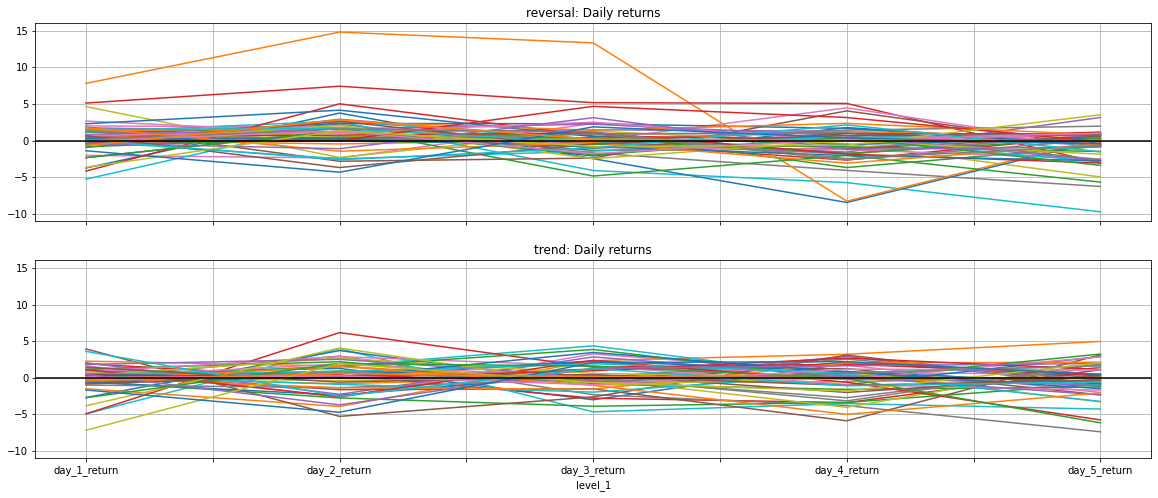

In [44]:
# 描画領域を定義
fig, axes = plt.subplots(
    len(results), 1, figsize=(20, 4 * len(results)), sharex=True, sharey=True
)

# 描画用データ保存用
dfs_plot = {}

# 戦略毎に処理
for i, k in enumerate(results.keys()):
    # 描画位置を指定
    ax = axes[i]
    # 列を行に変換
    dfs_plot[k] = (
        results[k]
        .set_index("date")
        .loc[
            :,
            [
                "day_1_return",
                "day_2_return",
                "day_3_return",
                "day_4_return",
                "day_5_return",
            ],
        ]
        .stack()
        .to_frame()
        .reset_index()
        .rename(columns={0: "return"})
    )
    # 作業用に変数設定
    df_plot = dfs_plot[k]
    # 曜日毎のreturnをプロット
    df_plot.groupby(["level_1", "date"]).first().unstack().plot(ax=ax, legend=False)
    # タイトルを設定
    ax.set_title(f"{k}: Daily returns")
    # リターンが0の位置に基準線を描画
    ax.axhline(y=0, color="black")
    # グリッドを表示
    ax.grid(True)
# 描画
plt.show()

### 5. 曜日別分析のためのバイオリンプロット

```
　上のグラフでは何が起きているかわかりにくいので、seabornのバイオリンプロット(link:https://seaborn.pydata.org/generated/seaborn.violinplot.html[リンク])を利用します。バイオリンプロットはデータの密度分布を確認できるグラフであり、統計的な差異がありそうな箇所を発見するために便利です。バイオリンの形状はカーネル密度推定による確率密度関数を表しており、バイオリンの中心部分に平均、中央値、25%タイル、75%タイルを示す箱が表示されています。
```

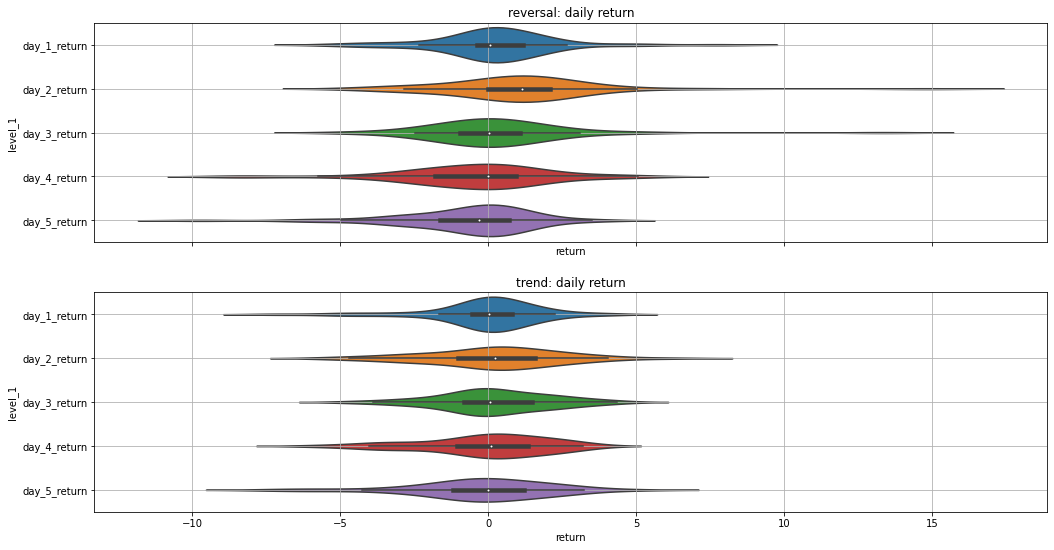

In [45]:
# 描画領域を定義
fig, axes = plt.subplots(len(results), 1, figsize=(15, 4 * len(results)), sharex=True, sharey=True)

# 戦略毎に処理
for i, k in enumerate(results.keys()):
    # 描画位置を指定
    ax = axes[i]
    # 箱が見やすいように横方向を指定してプロット
    sns.violinplot(x="return", y="level_1", data=dfs_plot[k], ax=ax, orient="h")
    # タイトルを設定
    ax.set_title(f"{k}: daily return")
    # グリッドを表示
    ax.grid(True)
# 文字が重なって読みにくいので間隔調整
fig.tight_layout(pad=2.0)
# 描画
plt.show()

　reversal/trendは木・金曜日に負ける傾向がありそうです。trendはプラス側の裾野が若干広いように思われます。これはトレンドフォローを行うと大きな勝ちが取れている可能性が示唆されます。

　取引戦略によっては月曜日に大きく勝つモデルや金曜日に大きく負けるなど曜日によって強さが異なることも多く、このような曜日ごとのプロットはその銘柄の特性を知る上で、確認する価値があります。特に曜日や月などの周期でチェックする場合、負けている方(このグラフでいうととマイナス側の分布)に注目することが重要です。周期性を狙って収益を意図的に取得することは難易度の高いテクニックですが、負けの場合は理由をしっかりと分析すると防げる可能性があるためです。例えば、よくあるのが金曜日特有の週末に発生するクローズオーダーなど、機関投資家のルールにより発生する取引です。

### 6. 週毎のリターンの累積プロット

　次にいよいよ取得した収益率の時系列を累積プロットします。まず、比較対象として取引対象の全銘柄の平均週次リターンを計算します。

In [46]:
# 変数名を調整します。
# backtest_priceはユニバースで絞り込み済みです
df_price = backtest_price

In [47]:
# 週毎に始値と終値を取得
df_wp = (
    # start_dt以降の日付のみ計算
    df_price.loc[df_price.index >= start_dt].sort_values(["Local Code", "EndOfDayQuote Date"])
    # 銘柄コード毎に処理
    .groupby("Local Code")
    # 月曜日スタートで週にリサンプル
    .resample("W-MON", label="left", closed="left")
    # 始値は最初のレコード、終値は最後のレコードを取得
    .agg({"EndOfDayQuote Open": "first", "EndOfDayQuote ExchangeOfficialClose": "last"})
    # マルチインデックスを解除
    .reset_index(level=[0])
)
# Open が 0.0 の銘柄は値段が付かなかった銘柄で、バックテストでは購入対象外であるため除外する
df_wp = df_wp.loc[df_wp.loc[:, "EndOfDayQuote Open"] != 0.0]
# 銘柄毎の週次リターンを計算
df_wp.loc[:, "universe"] = (
    (
        (
            df_wp.loc[:, "EndOfDayQuote ExchangeOfficialClose"]
            / df_wp.loc[:, "EndOfDayQuote Open"]
        )
        - 1
    )
    * 100
)
# ユニバースの週毎のリターンを計算します。
df_universe_return = df_wp.groupby(df_wp.index)["universe"].mean().to_frame()

　対比軸である取引対象の全銘柄の平均週次リターンが準備できたら、今回の取引戦略の結果と一緒にプロットしてみます。

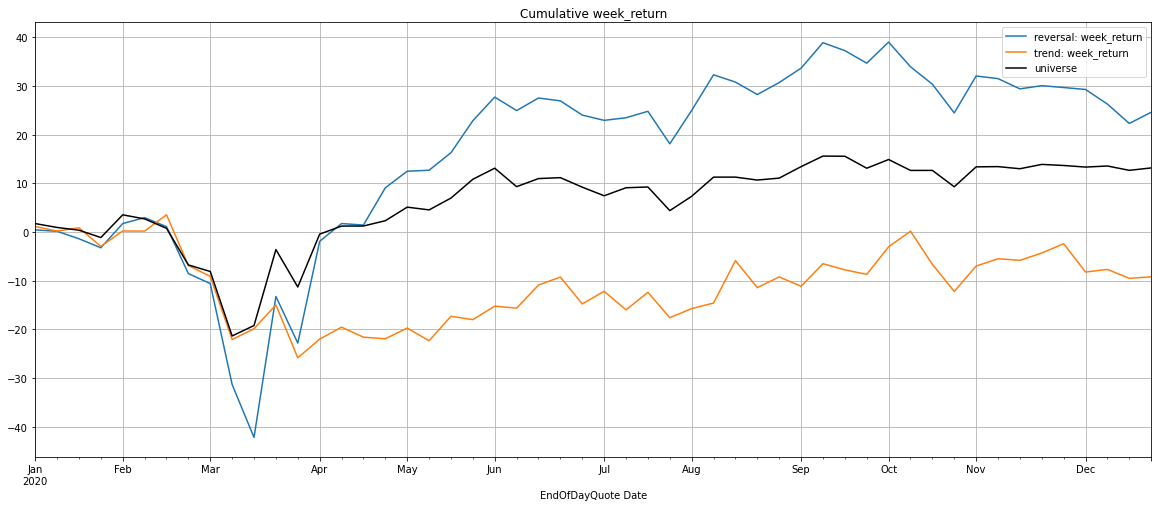

In [48]:
# 描画領域を定義
fig, axes = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)

# 戦略毎に処理
for k in results.keys():
    # 描画位置を指定
    ax = axes
    # 戦略別の累積リターンを描画
    results[k].set_index("date").loc[:, ["week_return"]].rename(
        columns={"week_return": f"{k}: week_return"}
    ).cumsum().plot(ax=ax)

# ユニバースの週次リターンの累積をプロット
df_universe_return.cumsum().plot(ax=ax, color="black", label="universe")

# 表示を調整
ax.set_title("Cumulative week_return")
# グリッドを表示
ax.grid(True)
# 描画
plt.show()

　このプロットは興味深いことがわかります。

　まずreversalは、3月に発生した負けが非常に大きいことがわかります。ベンチマークはおよそ-20%の負けとなっているのに対し、reversalでは-40%に到達しています。これはリターン・リバーサル戦略を採用した場合、マーケット暴落時に負けが積み重なる現象として知られています。一方、その後に0%近辺まで戻しているので3月後半から5月末にかけて、取得できたリターンは非常に大きいこともわかります。ただ、対比軸である取引対象の全銘柄の平均週次リターンには到達していません。その後、reversal戦略のユニバースに対する有意性は6月以降はあまり観測できず、12月までユニバースの平均に勝てないまま最終的に負けています。

　次に、trendは3月上旬の負けがユニバースの平均と比較すると小さいことがわかります。一方、reversal戦略の場合に観測された大きな収益性は観測できず、6月にユニバースの平均と同一の水準になると、以降はreversalと同等に12月までユニバースの平均に勝てないまま最終的に負けています。

### 7. ユニバースとの散布図

　ユニバースとリターンの散布図は、マーケットの動きに対してポートフォリオの運用実績がどのように分布するかを確認するために利用します。

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


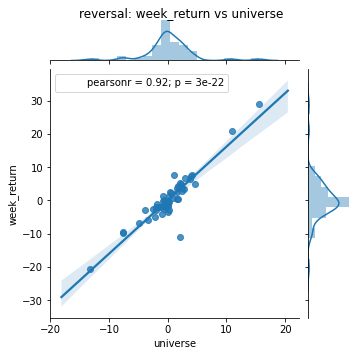

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


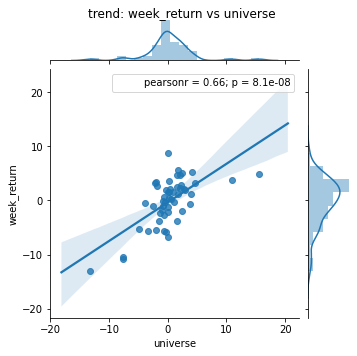

In [49]:
# 戦略毎に処理
for k in results.keys():
    # 散布図をプロット
    p = sns.jointplot(
        x=df_universe_return.iloc[:, 0],
        y=results[k].loc[:, "week_return"],
        kind="reg",
        height=5,
        stat_func=stats.pearsonr,
    )
    # タイトルを設定
    p.fig.suptitle(f"{k}: week_return vs universe")
    # タイトル表示用に位置を調整
    p.fig.subplots_adjust(top=0.95)
    # 描画
    plt.show()

　reversalはユニバースに対して、全体が下がった時に負けが大きく、ユニバースが上がった時に勝ちがわずかにユニバースを上回ることが観測できます。trendは分布が広がっており、ユニバースの影響をあまり受けていないことがわかります。また、0でリターンを稼いでいる週が多く観測出来、マーケットが動いていない時に細かく勝てている可能性が示唆されます。

### 8. ユニバースに対するベータを計算

　上記の傾向はベータを計算すると一目瞭然です。

In [50]:
# 結合用に保存
buff = []
# 戦略毎に処理
for k in results.keys():
    # ベータを計算
    res = stats.linregress(df_universe_return.iloc[:,0], results[k].loc[:, "week_return"])
    # 一覧表示用にデータフレームを作成
    df_beta = pd.DataFrame([res.slope], index=[k], columns=["beta"])
    # インデックス名を設定
    df_beta.index.name = "storategy_id"
    # 保存
    buff.append(df_beta)
# 結合して表示
pd.concat(buff)

,beta
storategy_id,
reversal,1.612183
trend,0.714063


　reversalはベータがおよそ1.6となっており、ユニバースが10%変動すると16%程度の変動が発生する取引戦略であることがわかります。ユニバースが-20%変動したときは-32%変動しますので、暴落時の大きな負けもこのベータ値の高さで説明ができます。3月のようにドローダウンが深くなる現象は、高いベータを持つ取引戦略にはよく観測されます。trendはベータが0.8近辺となっており、reversalと比較すると低いベータとなっています。

### 銘柄毎に分析するための準備

　最後に銘柄毎のデータを使用して分析していきます。

*各銘柄毎のデータ*

1. 銘柄毎の運用実績の分布をプロット
2. 銘柄毎のreturnの分布をプロット
3. 週毎の勝ち銘柄率をプロット、統計量の算出

銘柄毎のデータを使用して分析するために必要な計算を実施します。

In [51]:
# 分析用データ保存用
dfs_analyze = {}
# 戦略毎に処理
for i in stocks.keys():
    # 分析用にデータをコピー
    df_analyze = stocks[i].copy()
    # day5に必ず値が存在するように調整します
    df_analyze.loc[:, ["day_1", "day_2", "day_3", "day_4", "day_5"]] = (
        df_analyze.loc[:, ["day_1", "day_2", "day_3", "day_4", "day_5"]]
        .replace(0.0, np.nan)
        .ffill(axis=1)
    )
    # 終値とエントリーの差分を計算
    df_analyze.loc[:, "diff"] = df_analyze.loc[:, ["entry", "day_5"]].diff(axis=1)[
        "day_5"
    ]
    # 損益を計算します
    df_analyze.loc[:, "pl"] = df_analyze.loc[:, "diff"] * df_analyze.loc[:, "actual"]
    # リターンを計算します
    df_analyze.loc[:, "return"] = (
        (df_analyze.loc[:, "day_5"] / df_analyze.loc[:, "entry"]) - 1
    ) * 100
    # infを0.0に変換
    df_analyze = df_analyze.replace(np.inf, 0.0)
    # 処理結果を保存
    dfs_analyze[i] = df_analyze

### 1.銘柄毎の運用実績の分布をプロット

分析用データを表示して確認します

In [52]:
dfs_analyze["reversal"].tail(25)

,date,Local Code,budget,n,entry,day_1,day_2,day_3,day_4,day_5,bought,actual,diff,pl,return
0,2020-12-28,2929,50000,1275,2084.0,2085.0,2177.0,2032.0,2032.0,2032.0,47932.0,23,-52.0,-1196.0,-2.495202
1,2020-12-28,4592,50000,1276,1313.0,1319.0,1355.0,1337.0,1337.0,1337.0,49894.0,38,24.0,912.0,1.827875
2,2020-12-28,4055,50000,1277,5620.0,5840.0,5710.0,5730.0,5730.0,5730.0,44960.0,8,110.0,880.0,1.957295
3,2020-12-28,3921,50000,1278,2070.0,1996.0,2011.0,1999.0,1999.0,1999.0,49680.0,24,-71.0,-1704.0,-3.429952
4,2020-12-28,4493,50000,1279,3160.0,3175.0,3395.0,3410.0,3410.0,3410.0,47400.0,15,250.0,3750.0,7.911392
5,2020-12-28,4013,50000,1280,2561.0,2540.0,2720.0,2708.0,2708.0,2708.0,48659.0,19,147.0,2793.0,5.739945
6,2020-12-28,7034,50000,1281,3600.0,3515.0,3670.0,3650.0,3650.0,3650.0,46800.0,13,50.0,650.0,1.388889
7,2020-12-28,6049,50000,1282,1244.0,1275.0,1248.0,1286.0,1286.0,1286.0,49760.0,40,42.0,1680.0,3.376206
8,2020-12-28,7803,50000,1283,2248.0,2163.0,2205.0,2241.0,2241.0,2241.0,49456.0,22,-7.0,-154.0,-0.311388
9,2020-12-28,3788,50000,1284,8300.0,8440.0,8760.0,8850.0,8850.0,8850.0,49800.0,6,550.0,3300.0,6.626506


### 2.銘柄毎のリターンの分布をヒストグラムでプロット

銘柄毎の各週のデータを確認します。銘柄毎のリターンの分布をヒストグラムでまずはプロットします。

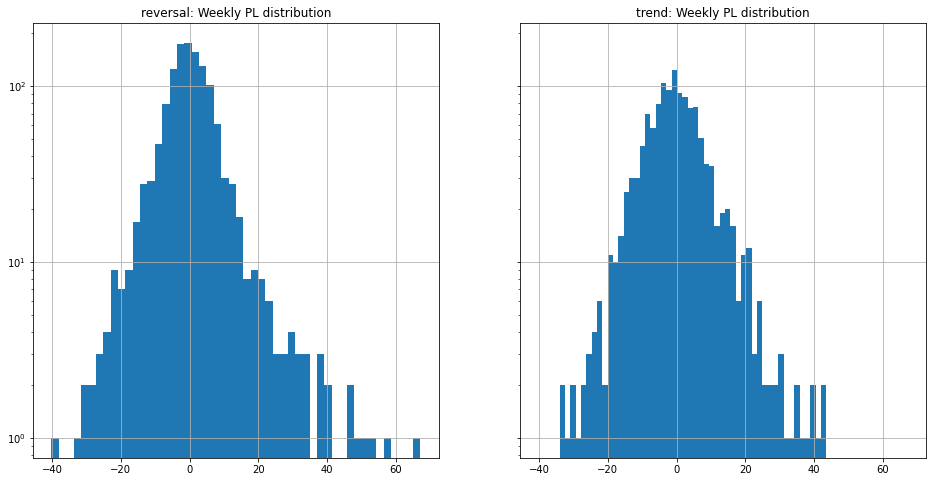

In [53]:
# 描画領域を定義
fig, axes = plt.subplots(1, len(dfs_analyze), figsize=(8 * len(dfs_analyze), 8), sharex=True, sharey=True)

# 戦略毎に処理
for i, k in enumerate(dfs_analyze.keys()):
    # 描画位置を指定
    ax = axes[i]
    # ヒストグラムをプロット
    dfs_analyze[k].groupby(["date", "Local Code"])["return"].sum().hist(bins=50, log=True, ax=ax)
    # タイトルを設定
    ax.set_title(f"{k}: Weekly PL distribution")
# 描画
plt.show()

　銘柄毎リターンの分布をプロットしてみましたが、ここから何か知見は得ることは難しそうです。上のプロットからもこれといった知見をえることはできません。あえて言うなら、reversalが若干trendと比較すると裾野が広い程度です。ただし、リターンを大きな勝ちに依存している戦略や、負けの裾野が非常に広い戦略などもこのプロットで観測できるため、リターンの分布は常に確認することをおすすめします。

### 3.週毎に勝ち銘柄率を算出、統計量の算出

最後に週毎の銘柄の勝率を確認します。

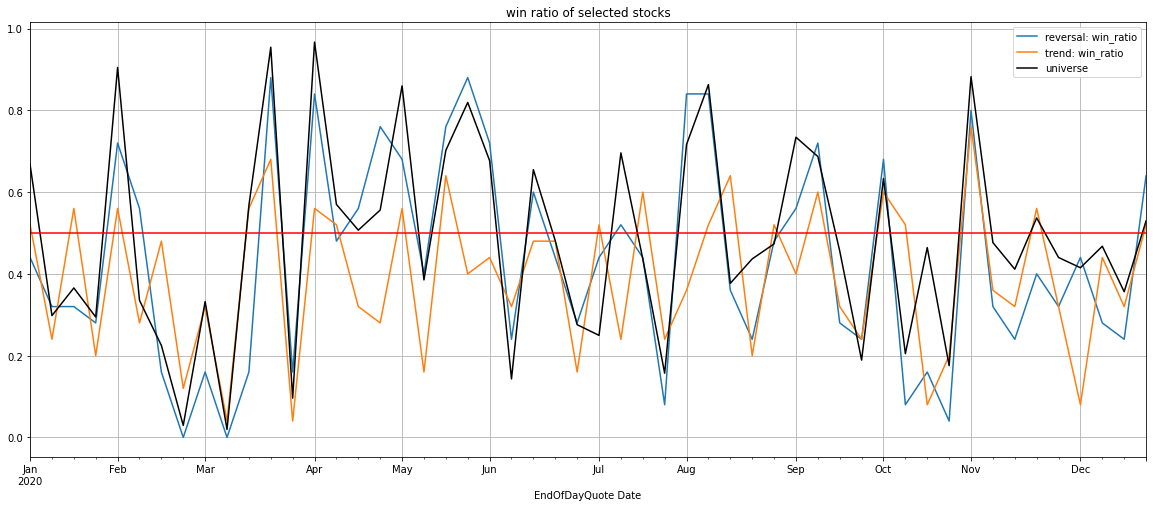

,count,mean,std,min,25%,50%,75%,max
reversal: win_ratio,52.0,0.432308,0.251868,0.00,0.24,0.42,0.65,0.88
trend: win_ratio,52.0,0.392308,0.181158,0.04,0.24,0.40,0.53,0.76


In [54]:
# 描画領域を定義
fig, ax = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)

# 統計量表示用
buff = []
# 戦略毎に処理
for k in dfs_analyze.keys():
    # 週毎の勝ち銘柄率を計算
    win_ratio = (
        dfs_analyze[k]
        .set_index("date")
        .groupby("date")
        .apply(lambda x: (x.pl > 0).sum() / x.shape[0])
        .to_frame()
        .rename(columns={0: f"{k}: win_ratio"})
    )
    # プロット
    win_ratio.plot(ax=ax)
    # 統計量を保存
    buff.append(win_ratio.describe().T)
# ユニバースの勝ち銘柄率をプロット
df_wp.groupby(df_wp.index).apply(lambda x: (x.universe > 0).sum() / x.shape[0]).rename(
    "universe"
).to_frame().plot(ax=ax, color="black")
# タイトルを設定
ax.set_title("win ratio of selected stocks")
# グリッド表示
ax.grid(True)
# 0.5に基準線を描画
ax.axhline(y=0.5, color="red")
#  描画
plt.show()
# 週毎の勝ち銘柄率の統計量
display(pd.concat(buff))

　このプロットは黒線のuniverseに対してどの時期に銘柄単位で勝率が低く、どの時期に勝率が高かったを確認しています。trendは暴落後にあまり収益を得ることができませんでしたが、revesalやunivereとの差異が観測できます。 +
もし、銘柄単位の勝率で大きな差異が発生していないのに、収益に差異が出ている場合はその時の銘柄の勝ち幅が大きい可能性があります。また、9月以降にもみ合いになってしまった時期はこの勝率でも50%近辺で揉み合っており、取引戦略の優位性が発揮できていない時期であることがわかります。

### 考察

　ここまででいろいろな観点からreversalとtrendの評価を実施してきました。3月末以降のリターン・リバーサル戦略が有効に働いている時期もありましたし、トレンドフォロー戦略でベータ値を低く抑える可能性があることがわかりました。

　基本的にリターン・リバーサル戦略とトレンドフォロー戦略は安定して勝てる手法ではなく、リバーサル・モメンタムという代表的なファクターと密接な関係があり、マーケットの局面ごとに有効な戦略が変わっていることが知られています。ここまでの結果から、適切にリターン・リバーサル戦略とトレンドフォロー戦略をモデルで切り替えることが実現できれば、高い収益が実現できるポテンシャルがありそうです。そのような機械学習モデルの構築を検討する価値はあるでしょう。

　このように様々な可視化を通して、取引戦略を評価することで、取引戦略を発展させていくことができます。

## 8. 投稿用パッケージのディレクトリ作成

```
　ここまで、モデルの作成及び評価をしてきました。ここからは、投稿用のパッケージを作成します。ランタイム環境用のモデルは以下の構成である必要がありますので、まずは必要なディレクトリを作成していきます。

[source]
----
.
├── model                  必須 学習済モデルを置くディレクトリ
│   └── ...
├── src                    必須 Python のプログラムを置くディレクトリ
│   ├── predictor.py       必須 最初にプログラムが呼び出すファイル
│   └── ...                その他のファイル (ディレクトリも作成可能)
└── requirements.txt       任意

----
```

In [55]:
# 作業用のディレクトリを設定
if 'google.colab' in sys.modules:
    working_dir = "/content/drive/MyDrive/JPX_Competition/Chapter03"
else:
    working_dir = "."
# パッケージのrootディレクトリ
package_dir = f"{working_dir}/archive"

In [56]:
# 必要なディレクトリを作成します
os.makedirs(f"{package_dir}/model", exist_ok=True) 
os.makedirs(f"{package_dir}/src", exist_ok=True) 
# 今回はmodelディレクトリに保存するファイルがないため空ファイルを作成します
open(f"{package_dir}/model/dummy.txt", mode="a").close()

## 9. 作成したコードをランタイム実行用にクラスにまとめる

　notebookの各セルで実行する内容をファイルに書き出すために、jupyter notebookにマジックコマンドを追加します。

In [57]:
# jupyter notebookにマジックコマンドを追加します
# セル実行と同時にセル内の記載内容をファイルに書き込みます
@register_cell_magic
def writerun(line, cell):
    # 書き込み先ファイルパスを取得
    file_path = line.split()[-1]
    # 親ディレクトリ名を取得
    p_dir = os.path.dirname(file_path)
    # 親ディレクトリが存在する場合は
    if p_dir != "":
        # ディレクトリ作成
        os.makedirs(p_dir, exist_ok=True)
    # cellの内容をファイルに書き込み
    with open(file_path, mode="w") as f:
        f.write(cell)
    # cellを実行
    get_ipython().run_cell(cell)

　以下のコードは、ここまでに一行ずつ作成したコードを投稿用の `ScoringService` としてまとめて実装したものになります。また、今回は学習済モデルのパラメーターなどをファイルに書き出していないため、`get_model` メソッドでは何もせずにTrueを返しています。そして、`predict` メソッドには上記で実行したコードをコピーして貼り付けています。表示用のコードおよび作業用データのコピーについてはランタイム環境では実行する必要がないため削除しています。

　jupyter notebookのセルに `ScoringService` クラスを作成している理由は、`ScoringService` クラスの出力するポートフォリオがこれまで検証してきたポートフォリオと同一であることの検証が容易であるためです。慣れている方は直接`predictor.py` ファイル上で作業することを好まれるかもしれません。

　次のセルでは、セルの先頭で `writerun` マジックコマンドを指定することで、実行時にセルの内容が `$package_dir/src/predictor.py` ファイルに書き込まれます。すでにファイルが存在している場合は上書きされるためご注意ください。

In [58]:
%%writerun $package_dir/src/predictor.py
# -*- coding: utf-8 -*-
import io

import pandas as pd


class ScoringService(object):
    @classmethod
    def get_model(cls, model_path="../model"):
        return True

    @classmethod
    def predict(
        cls, inputs, start_dt=pd.Timestamp("2021-02-01"), strategy_id="reversal"
    ):
        ####
        # データセットを読み込みます
        ####
        # 銘柄情報読み込み
        df_stock_list = pd.read_csv(inputs["stock_list"])
        # 問題2のユニバース (投資対象銘柄群) 取得
        codes = df_stock_list.loc[
            df_stock_list.loc[:, "universe_comp2"] == True, "Local Code"
        ].unique()

        # 価格情報読み込み、インデックス作成
        df_price = pd.read_csv(inputs["stock_price"]).set_index("EndOfDayQuote Date")
        # 日付型に変換
        df_price.index = pd.to_datetime(df_price.index, format="%Y-%m-%d")

        if "purchase_date" in inputs.keys():
            # ランタイム環境では指定された投資対象日付を使用します
            # purchase_dateを読み込み
            df_purchase_date = pd.read_csv(inputs["purchase_date"])
            # purchase_dateの最も古い日付を設定
            start_dt = pd.Timestamp(df_purchase_date.sort_values("Purchase Date").iloc[0, 0])

        # 投資対象日の前週金曜日時点で予測を出力するため、予測出力用の日付を設定します。
        pred_start_dt = pd.Timestamp(start_dt) - pd.Timedelta("3D")
        # 特徴量の生成に必要な日数をバッファとして設定
        n = 30
        # データ絞り込み日付設定
        data_start_dt = pred_start_dt - pd.offsets.BDay(n)
        # 日付で絞り込み
        filter_date = df_price.index >= data_start_dt
        # 銘柄をユニバースで絞り込み
        filter_universe = df_price.loc[:, "Local Code"].isin(codes)
        # 絞り込み実施
        df_price = df_price.loc[filter_date & filter_universe]

        ####
        # シンプルな特徴量を作成します
        ####
        # groupby を使用して処理するために並び替え
        df_price.sort_values(["Local Code", "EndOfDayQuote Date"], inplace=True)
        # 銘柄毎にグループにします。
        grouped_price = df_price.groupby("Local Code")[
            "EndOfDayQuote ExchangeOfficialClose"
        ]
        # 銘柄毎に20営業日の変化率を作成してから、金曜日に必ずデータが存在するようにリサンプルしてフィルします
        #df_feature = grouped_price.apply(
        #    lambda x: x.pct_change(20).resample("B").ffill().dropna()
        #).to_frame()

        # 銘柄毎に終値と25営業日の単純移動平均線の乖離を作成してから、金曜日に必ずデータが存在するようにリサンプルしてフィルします
        df_feature = grouped_price.apply(
            lambda x: (x / (x.rolling(25).mean())).resample("B").ffill().dropna()
        ).to_frame()

        # 上記が比較的時間のかかる処理なので、処理済みデータを残しておきます。
        df_work = df_feature  # copyはランタイム実行時には不要なので削除しています

        # インデックスが銘柄コードと日付になっているため、日付のみに変更します。
        df_work = df_work.reset_index(level=[0])
        # カラム名を変更します
        df_work.rename(
            columns={"EndOfDayQuote ExchangeOfficialClose": "pct_change"},
            inplace=True,
        )
        # データをpred_start_dt以降の日付に絞り込みます
        df_work = df_work.loc[df_work.index >= pred_start_dt]

        ####
        # ポートフォリオを組成します
        ####
        # 金曜日のデータのみに絞り込みます
        df_work = df_work.loc[df_work.index.dayofweek == 4]

        # 日付毎に処理するためグループ化します
        grouped_work = df_work.groupby("EndOfDayQuote Date", as_index=False)

        # 選択する銘柄数を指定します
        number_of_portfolio_stocks = 25

        # ポートフォリオの組成方法を戦略に応じて調整します
        strategies = {
            # リターン・リバーサル戦略
            "reversal": {"asc": True},
            # トレンドフォロー戦略
            "trend": {"asc": False},
        }

        # 戦略に応じたポートフォリオを保存します
        df_portfolios = {}

        # strategy_id が設定されていない場合は全ての戦略のポートフォリオを作成します
        if "strategy_id" not in locals():
            strategy_id = None

        for i in [strategy_id] if strategy_id is not None else strategies.keys():
            #  日付毎に戦略に応じた上位25銘柄を選択します。
            df_portfolios[i] = grouped_work.apply(
                lambda x: x.sort_values(
                    "pct_change", ascending=strategies[i]["asc"]
                ).head(number_of_portfolio_stocks)
            )

        # 銘柄ごとの購入金額を指定
        budget = 50000
        # 戦略毎に処理
        for i in df_portfolios.keys():
            # 購入株式数を設定
            df_portfolios[i].loc[:, "budget"] = budget

            # インデックスを日付のみにします
            df_portfolios[i].reset_index(level=[0], inplace=True)
            # 金曜日から月曜日日付に変更
            df_portfolios[i].index = df_portfolios[i].index + pd.Timedelta("3D")

        ####
        # 出力を調整します
        ####
        # 戦略毎に処理
        for i in df_portfolios.keys():
            # インデックス名を設定
            df_portfolios[i].index.name = "date"
            # 出力するカラムを絞り込みます
            df_portfolios[i] = df_portfolios[i].loc[:, ["Local Code", "budget"]]

        # 出力保存用
        outputs = {}
        # 戦略毎に処理
        for i in df_portfolios.keys():
            # 出力します
            out = io.StringIO()
            # CSV形式で出力
            df_portfolios[i].to_csv(out, header=True)
            # 出力を保存
            outputs[i] = out.getvalue()

        return outputs[strategy_id]


ファイルが書き込まれていることを確認します

In [59]:
! ls -l $package_dir/src/

total 7
-rw------- 1 root root 6341 Apr  5 13:32 predictor.py


　作成したクラスが適切に動くかを動作確認します。 上記で1行ずつ実行した場合と同一の出力であれば良いことになります。

In [60]:
# 動作確認します
str_ret = ScoringService.predict(inputs, start_dt=pd.Timestamp("2020-01-01"))

In [61]:
# 出力を確認
print("\n".join(str_ret.split("\n")[:10]))

date,Local Code,budget
2020-01-06,4592,50000
2020-01-06,4571,50000
2020-01-06,6049,50000
2020-01-06,3254,50000
2020-01-06,6875,50000
2020-01-06,7744,50000
2020-01-06,2395,50000
2020-01-06,3660,50000
2020-01-06,3549,50000


In [62]:
# 出力を保存
with open("chapter03-tutorial-01-class.csv", mode="w") as f:
    f.write(str_ret)

出力が一致していることを確認します

In [63]:
assert outputs["reversal"] == str_ret

## 10. 提出用パッケージの作成と提出

```
3.7.10で作成した `ScoringService` を `predictor.py` に書き込み、Zip形式で圧縮します。今回はシンプルな特徴量を使用してポートフォリオを作成しているため、学習済みのモデルファイルは存在しません。ただし、modelディレクトリは必須であるため、zipファイルには該当のディレクトリを含める必要があります。そのためには、modelファイルには何らかのダミーファイルを作成してzipファイルを作成すると良いでしょう。

以下、Zipファイル作成例になります。
[source,bash]
----
$ mkdir model src
$ touch model/dummy.txt
$ ls
model src
$ zip -v submit.zip src/predictor.py model/dummy.txt
----
```


In [64]:
# 提出用パッケージ名
package_file = "chapter03-model.zip"
# パッケージファイルパス
package_path = f"{working_dir}/{package_file}"

# zipファイルを作成
with zipfile.ZipFile(package_path, "w") as f:
    # model/dummy.txtを追加
    print(f"[+] add {package_dir}/model/dummy.txt to model/dummy.txt")
    f.write(f"{package_dir}/model/dummy.txt", "model/dummy.txt")
    # src/predictor.py を追加
    print(f"[+] add {package_dir}/src/predictor.py to src/predictor.py")
    f.write(f"{package_dir}/src/predictor.py", "src/predictor.py")

print(f"[+] please check {package_path}")

[+] add /content/drive/MyDrive/JPX_Competition/Chapter03/archive/model/dummy.txt to model/dummy.txt
[+] add /content/drive/MyDrive/JPX_Competition/Chapter03/archive/src/predictor.py to src/predictor.py
[+] please check /content/drive/MyDrive/JPX_Competition/Chapter03/chapter03-model.zip


　以上で投稿用のモデルパッケージは完成です。`chapter03-model.zip` ファイルをコンペティションページから投稿してリーダーボードに掲載されることを確認しましょう。

　リーダーボードに掲載されたことを確認したら、例えば、特徴量を変更してみたり、複数の特徴量それぞれから10銘柄ずつ選択するロジックを実装してみるのはどうでしょうか。いくつかの特徴量については「<<anchor-2.7,2.7. 特徴量の生成>>」で説明していますのでご参照ください。特に、「2.7.2. 定常性を意識した特徴量設計」は重要な概念ですのでご一読ください。

次章では、2章で作成した機械学習モデルを使用してポートフォリオを組成する方法について記載しています。